In [1]:
import time
t1 = time.time()
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')
import monod
from monod import analysis
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# dir_string = './fits/gg_230316_026_brain_nuc_4_1'


In [3]:
dataset_meta_sc = [f'brain_10x_30k_{i}' for i in range(1,5)]
dataset_meta_sn = [f'brain_nuc_10x_30k_{i}' for i in range(1,5)]
pair_ind = 3
dataset_names= [dataset_meta_sc[pair_ind],dataset_meta_sn[pair_ind]]
n_datasets = len(dataset_names)


In [90]:
dir_string = './fits/gg_230316_026_brain_nuc_4_1'
dataset_strings = [dir_string + '/' + x for x in dataset_names]
# result_strings = [dir_string + '/'+x+'/Bursty_Poisson_10x11/grid_scan_results_upd.res' for x in dataset_names]
result_strings = [dir_string + '/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]


In [91]:
sd_arr = [monod.analysis.load_search_data(x+'/raw.sd') for x in dataset_strings]


In [92]:
def plot_stat(X,Y,stat,ax1,modality='spliced',plot_offset=True):
    if stat=='mean':
        stat_fun = lambda x: x.mean(1)
    elif stat=='CV2':
        stat_fun = lambda x: (x.var(1))/(x.mean(1)**2)
    
    x = stat_fun(X)
    y = stat_fun(Y)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1.scatter(x,y,1,'k',alpha=0.3)
    xl = np.linspace(x.min(),x.max())
    ax1.plot(xl,xl,'--',color='crimson',linewidth=4)
    if plot_offset:
        offset = y.mean()/x.mean()
        print('Offset: {:.2f}'.format(np.log10(offset)))
        ax1.plot(xl,xl*offset,color='lightseagreen',linewidth=2)
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel('single-cell {} {}'.format(stat,modality))
    ax1.set_ylabel('single-nucleus {} {}'.format(stat,modality))


Offset: 0.08
Offset: -0.15
Offset: 0.51
Offset: -0.31


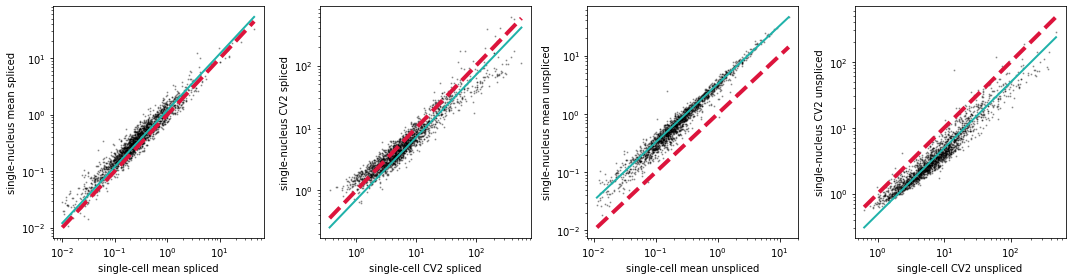

In [93]:
fig1,ax1=plt.subplots(1,4,figsize=(15,4))
plot_stat(sd_arr[0].layers[1],sd_arr[1].layers[1],'mean',ax1[0],'spliced')
plot_stat(sd_arr[0].layers[1],sd_arr[1].layers[1],'CV2',ax1[1],'spliced')
plot_stat(sd_arr[0].layers[0],sd_arr[1].layers[0],'mean',ax1[2],'unspliced')
plot_stat(sd_arr[0].layers[0],sd_arr[1].layers[0],'CV2',ax1[3],'unspliced')
fig1.tight_layout()


In [111]:
sr_arr = [monod.analysis.load_search_results(x) for x in result_strings]

In [112]:
# for k in range(2):
#     sr_arr[k].find_sampling_optimum()

In [113]:
# # q = np.quantile(logL_2d,0.9)
# # ax1[1].pcolor(X,Y,np.ma.masked_array(logL_2d,logL_2d<q),
# #               cmap=cmap_logl,
# #               alpha=1,hatch='///',edgecolor='magenta',facecolor=None,linewidth=0,
# #               vmin=vmin,vmax=vmax)
# vmin,vmax = (logL_2d.min(),logL_2d.max())
# mesh = ax1[1].pcolormesh(X,Y,(logL_2d),cmap=cmap_logl,vmin=vmin,vmax=vmax)


In [120]:
from matplotlib.colors import ListedColormap

c1 = [173/255,214/255,200/255]
c2 = [59/255,131/255,130/255]
ncol=50
cmap_histogram = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(3)]).T)

def plot_landscape(sr,ax):
    x_ = np.unique(sr.sp.X)
    y_ = np.unique(sr.sp.Y)
    nX = len(x_)
    nY = len(y_)
    X,Y = np.meshgrid(x_,y_,indexing='ij')
    kld = np.reshape(np.log10(sr.klds.sum(1)),sr.sp.gridsize)
#     print(kld)
    vmin = kld.min()
    vmax = kld.max()
    ax.pcolormesh(X,Y,(kld),cmap=cmap_histogram,vmin=vmin,vmax=vmax)
    q = np.quantile(kld,0.05)
    ax.pcolor(X,Y,np.ma.masked_array(kld,kld>q),
                  cmap=cmap_histogram,
                  alpha=1,hatch='///',edgecolor='darkorange',facecolor=None,linewidth=0,
                  vmin=vmin,vmax=vmax)

    #     print(kld.shape)
#     print(X.shape)
    # logL_2d = np.zeros((nX,nY))


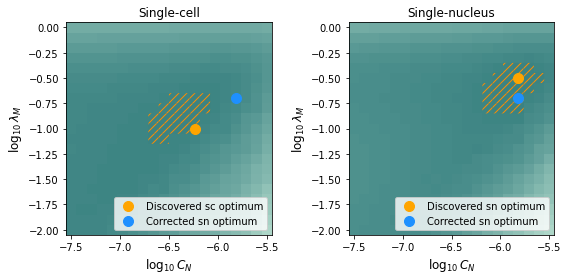

In [129]:
fs=12
fig1,ax1= plt.subplots(1,2,figsize=(8,4))
names = ['Single-cell','Single-nucleus']
abbr_names = ['sc','sn']
arbitrary_v3_params = np.asarray(sr_arr[0].samp_optimum)+0.5
arbitrary_v3_ind = np.argmin(((sr_arr[1].param_estimates[:,~sr_arr[0].rejected_genes,:] - sr_arr[0].phys_optimum[~sr_arr[0].rejected_genes])**2)[:,:,:2].sum((1,2)))
arbitrary_v3_pars = sr_arr[1].sp.sampl_vals[arbitrary_v3_ind]
for k in range(2):
    plot_landscape(sr_arr[k],ax1[k])
    ax1[k].scatter(sr_arr[k].samp_optimum[0],sr_arr[k].samp_optimum[1],100,c='orange',label='Discovered {} optimum'.format(abbr_names[k]))
    ax1[k].scatter(arbitrary_v3_pars[0],arbitrary_v3_pars[1],100,c='dodgerblue',label='Corrected sn optimum')
    ax1[k].set_xlabel(r'$\log_{10} C_N$',fontsize=fs)
    ax1[k].set_ylabel(r'$\log_{10} \lambda_M$',fontsize=fs)
    ax1[k].set_title(names[k],fontsize=fs)
    ax1[k].legend(loc='lower right')
fig1.tight_layout()
plt.savefig('./figs/brain_nuc_landscape.png',dpi=450)
plt.savefig('./figs/brain_nuc_landscape.pdf')

(-6.2368421052631575, -1.0)
(-5.815789473684211, -0.7)
0.9176619631003446
0.9715715663504423
0.9486332223152314


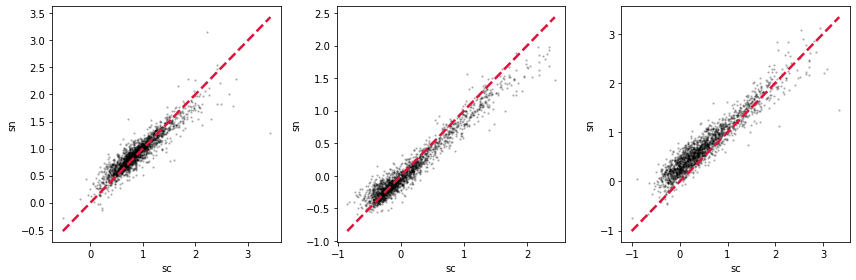

In [107]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
gf = (~sr_arr[1].rejected_genes)&(~sr_arr[0].rejected_genes)
arbitrary_v3_params = np.asarray(sr_arr[0].samp_optimum)+0.5
# arbitrary_v3_ind = np.argmin(((np.asarray(sr_arr[0].sp.sampl_vals)-arbitrary_v3_params)**2).sum(1))
arbitrary_v3_ind = np.argmin(((sr_arr[1].param_estimates[:,~sr_arr[0].rejected_genes,:] - sr_arr[0].phys_optimum[~sr_arr[0].rejected_genes])**2)[:,:,:2].sum((1,2)))
sr_arr[1].set_sampling_optimum(arbitrary_v3_ind)
print(sr_arr[0].samp_optimum)
print(sr_arr[1].samp_optimum)
for j in range(3):
    x = sr_arr[0].phys_optimum[gf,j]
    y = sr_arr[1].phys_optimum[gf,j]
    print(np.corrcoef(x,y)[0,1])
    ax1[j].scatter(x,y,2,'k',alpha=0.2)
    xl = np.linspace(min(x),max(x))
    ax1[j].plot(xl,xl,'--',color='crimson',linewidth=2.5)
    ax1[j].set_xlabel('sc')
    ax1[j].set_ylabel('sn')
fig1.tight_layout()